# **Unsupervised or Traditional Machine Learning Approach: Training the Model**

---



Guide used: https://www.youtube.com/watch?v=tHL5STNJKag&list=WL&index=1&t=817s

# **Setup**

In [1]:
!pip install joblib
!pip install tqdm
!pip install ipywidgets

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------- ----------- 1.6/2.2 MB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 5.6 MB/s eta 0:00:00

   ------------- -------------------------- 1/3 [jupyterlab_widgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   ---------------------------------------- 3/3 [ipywidgets]



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import joblib
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from PIL import Image

In [3]:
# drive.mount('/content/drive')

In [4]:
# full dataset path
dataset_dir = r"C:\Users\Kathleen Jocson\Desktop\train"



# **Data Preprocessing**

In [5]:
class SugarcaneDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.dataset = ImageFolder(root=root_dir, transform=transform)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    return self.dataset[idx]

  @property
  def classes(self):
    return self.dataset.classes

In [6]:
# This will Transform an image to a certain size, convert it to tensor, and normalize the pixel values
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
# Converts each image to a tuple of the form (tensor, label) using 'transform' defined earlier
# Assigns a number to each category of sugarcane disease in the dataset
dataset  = SugarcaneDataset(root_dir=dataset_dir, transform=transform)



In [8]:
# Get the number assigned to each disease (folder name)
dataset_label_to_class = {v: k for k, v in dataset.dataset.class_to_idx.items()}
print(dataset_label_to_class)




{0: 'Banded_Chlorosis', 1: 'Brown_Rust', 2: 'Brown_Spot', 3: 'Healthy', 4: 'Viral', 5: 'Yellow_Leaf'}


In [9]:
len(dataset)

4314

In [10]:
dataset[45][0].shape

torch.Size([3, 224, 224])

# **Model building**

In [11]:
# Pre-trained resnet18 without the classification layer will be used for feature extraction
# Random forest classifier will be used for classification
# The output of the feature extractor will be the input to the classifier

class SugarcaneDiseaseFeatureExtractor(nn.Module):
  def __init__(self, num_classes=6):
    super(SugarcaneDiseaseFeatureExtractor, self).__init__()
    self.base_model = timm.create_model('resnet18', pretrained=True, num_classes=0)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])

  def forward(self, x):
    # Flattens the extracted features since it will be used as input to random forest
    features = self.features(x).reshape(x.size(0), -1)
    return features


class SugarcaneClassifierWrapper:
    '''
    Contains the feature extractor, classifier, transform and classes
    '''
    def __init__(self, feature_extractor, classifier, transform, classes):
        self.feature_extractor = feature_extractor
        self.classifier = classifier
        self.transform = transform
        self.classes = classes
        self.feature_extractor.eval()

    def extract_features(self, dataloader):
        '''
        Extracts features from the given dataloader.
        Returns the features and the labels.
        '''
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        features, labels = [], []
        with torch.no_grad():
            for imgs, lbls in tqdm(dataloader):
                imgs = imgs.to(device)
                feats = self.feature_extractor(imgs)
                features.append(feats.cpu().numpy())
                labels.extend(lbls.numpy())
        return np.concatenate(features), np.array(labels)

    def train(self, dataloader, n_estimators=100, criterion='entropy', random_state=42, n_splits=5):
        """
        Train the model on the given dataloader.

        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Extracting features...")
        X_train, y_train = self.extract_features(dataloader)
        print("Performing cross-validation...")
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        scores = cross_val_score(self.classifier, X_train, y_train, cv=kf, scoring='f1_weighted')
        print("Fold scores (f1 weighted):", scores)
        print("Mean F1:", np.mean(scores))
        print("Training the classifier...")
        self.classifier.fit(X_train, y_train)
        print("Training complete.")

    def evaluate(self, dataloader):
        """
        Evaluate the model on the given dataloader.
        Prints the accuracy and confusion matrix.

        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Extracting features...")
        X_test, y_test = self.extract_features(dataloader)
        y_pred = self.classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        print("Accuracy:", accuracy)
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.classes, yticklabels=self.classes)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()


    def predict(self, image_path):
        """
        Predict the class of the given image.

        """
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0)
        with torch.no_grad():
            features = self.feature_extractor(image_tensor)
        return self.classes[self.classifier.predict(features.numpy())[0]]



# **Training**

In [12]:
# Setting up the dataloaders
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [13]:
# Initializing the feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = SugarcaneDiseaseFeatureExtractor().to(device)

# Initializing the classifier (Random forest)
classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)

# Creating the pipeline
model = SugarcaneClassifierWrapper(feature_extractor, classifier, transform, dataset_label_to_class)

# Training
model.train(dataloader)





Extracting features...


  0%|          | 0/135 [00:00<?, ?it/s]

Performing cross-validation...
Fold scores (f1 weighted): [0.91565837 0.9172357  0.90974192 0.92187229 0.91909979]
Mean F1: 0.9167216146076858
Training the classifier...
Training complete.


In [14]:
# Saving the model
import joblib
joblib.dump(model, "sugarcane_rf_model.pkl")

['sugarcane_rf_model.pkl']

# Evaluate Model

Extracting features...


  0%|          | 0/7 [00:00<?, ?it/s]

Accuracy: 0.9577464788732394
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        14
           1       1.00      0.88      0.93         8
           2       0.91      1.00      0.95        77
           3       1.00      1.00      1.00        30
           4       1.00      0.97      0.99        34
           5       1.00      0.92      0.96        50

    accuracy                           0.96       213
   macro avg       0.97      0.93      0.95       213
weighted avg       0.96      0.96      0.96       213



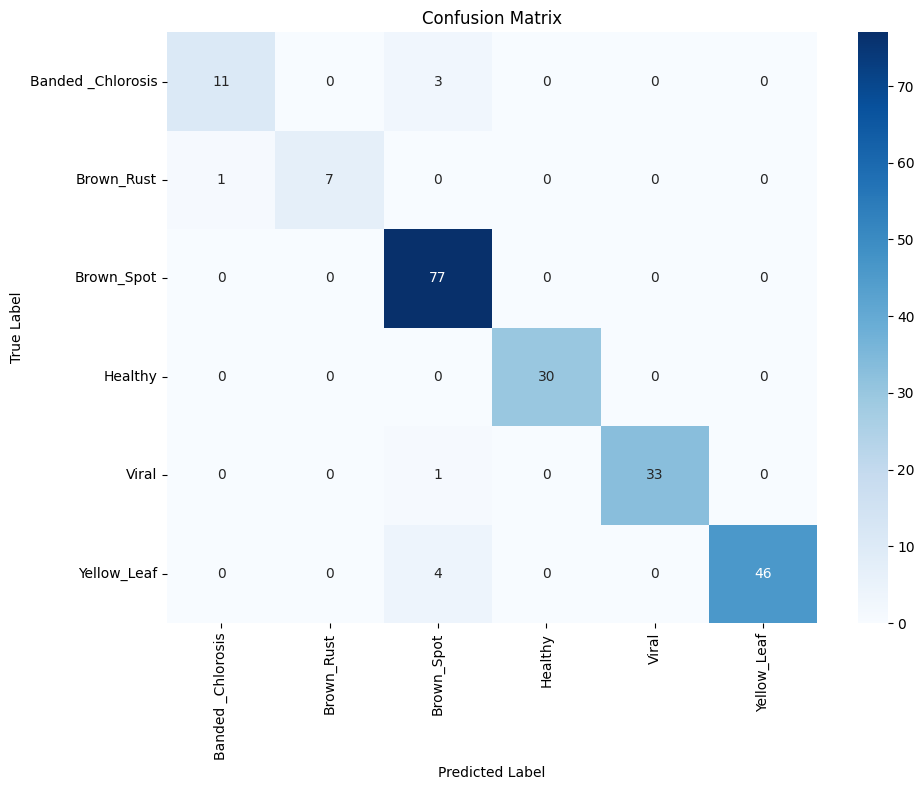

In [16]:
# The input should be in the same format as the training dataset (folder structure, folder names (except root dir), and all)
test_dir = r"C:\Users\Kathleen Jocson\Desktop\full" 
test_dataset  = SugarcaneDataset(root_dir=test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)
model.classes = test_dataset.classes
model.evaluate(test_dataloader)
